In [ ]:
# ! git clone https://github.com/krasserm/super-resolution.git

In [17]:
!unzip super-resolution_train.zip

Archive:  super-resolution_train.zip
 extracting: super-resolution_train/.gitignore  
  inflating: super-resolution_train/article.ipynb  
  inflating: super-resolution_train/data.py  
   creating: super-resolution_train/demo/
  inflating: super-resolution_train/demo/0829x4-crop.png  
  inflating: super-resolution_train/demo/0851x4-crop.png  
  inflating: super-resolution_train/demo/0869x4-crop.png  
   creating: super-resolution_train/docs/
   creating: super-resolution_train/docs/images/
  inflating: super-resolution_train/docs/images/figure_1.png  
  inflating: super-resolution_train/docs/images/figure_2.png  
  inflating: super-resolution_train/docs/images/figure_3.png  
  inflating: super-resolution_train/docs/images/figure_4.png  
  inflating: super-resolution_train/docs/images/figure_5.png  
  inflating: super-resolution_train/docs/images/figure_6.png  
  inflating: super-resolution_train/docs/images/result-edsr.png  
  inflating: super-resolution_train/docs/images/result-srgan.p

In [24]:
%cd super-resolution_train

[Errno 2] No such file or directory: 'super-resolution_train'
/content/super-resolution_train


In [25]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline

In [20]:
# Location of model weights (needed for demo)
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

In [26]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')



In [27]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

Caching decoded images in .div2k/caches/DIV2K_train_LR_bicubic_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_LR_bicubic_X4.cache.
3530612736/3530603713 [==============================] - 153s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_HR.cache.
31514624/31505881 [==============================] - 2s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_LR_bicubic_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_LR_bicubic_X4.cache.
449003520/448993893 [==============================] - 20s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_HR.cache.


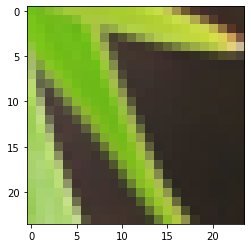

In [28]:
import matplotlib.pyplot as plt

dd = valid_ds.take(1)
for image, label in dd:
  lr = image[2]
  hr = label[2]

plt.imshow(lr)

In [30]:
from model.srgan import generator
from train import SrganGeneratorTrainer

# Create a training context for the generator (SRResNet) alone.

# while traning set input_size to 24x24 and fixed batch_size (tf.nn.conv2d_transpose need fixed graph)
pre_trainer = SrganGeneratorTrainer(model=generator(input_size=24, batch_size=16), checkpoint_dir=f'.ckpt/pre_generator2')

# Pre-train the generator 
pre_trainer.train(train_ds, valid_ds.take(10), steps=30, evaluate_every=10)

# Save weights of pre-trained generator
pre_trainer.model.save_weights('weights/srgan/pre_generator.h5')

10/30: loss = 5285.389, PSNR = 13.593482 (17.37s)
20/30: loss = 6031.986, PSNR = 12.670795 (36.17s)
30/30: loss = 5298.135, PSNR = 11.693690 (30.36s)


In [31]:
from model.srgan import generator, discriminator
from train import SrganTrainer

# Create a new generator and init it with pre-trained weights.

# To train with fixed graph, explicitly declare input_size and batch_size for training
gan_generator = generator(input_size=24, batch_size=16)
dis = discriminator()

gan_generator.load_weights('weights/srgan/pre_generator.h5')
# dis.load_weights('weights/srgan/gan_discriminator.h5')

# Create a training context for the GAN (generator + discriminator).
gan_trainer = SrganTrainer(generator=gan_generator, discriminator=dis)


# Train the GAN with 200,000 steps.
gan_trainer.train(train_ds, steps=5)

# Save weights of generator and discriminator.
gan_trainer.generator.save_weights('weights/srgan/gan_generator.h5')
gan_trainer.discriminator.save_weights('weights/srgan/gan_discriminator.h5')

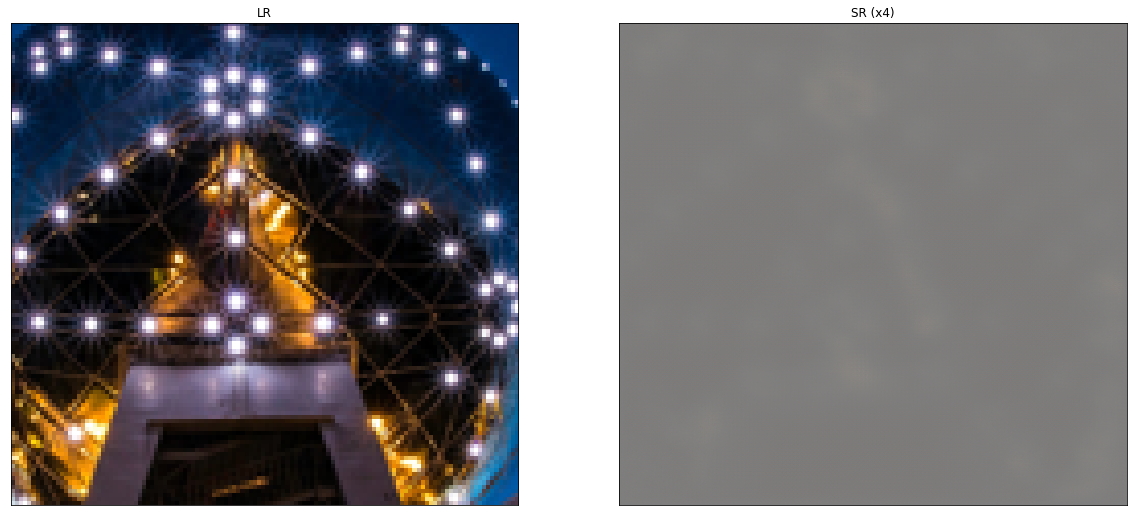

In [32]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3
from model.srgan import generator
from model import resolve_single
from utils import load_image, plot_sample

lr = load_image('demo/0851x4-crop.png')
lr = tf.cast(lr, dtype=tf.uint8)


shape = (lr.shape[0], lr.shape[1])  # input size of lr

model = generator(input_size=shape) # create model with lr input size
model.load_weights('weights/srgan/gan_generator.h5')
sr = resolve_single(model, lr)




plot_sample(lr, sr)

# tf.keras.utils.save_img('/content/super-resolution/demo/lr_cat.png', lr)
# tf.keras.utils.save_img('/content/super-resolution/demo/sr_cat.png', sr)

In [33]:
from model.srgan import generator
from model import resolve_single
from utils import load_image, plot_sample


model = generator(input_size=24)   # For inference can set arbitrary input size
model.load_weights('weights/srgan/gan_generator.h5')

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 24, 24, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_175 (Separable (None, 24, 24, 64)   499         lambda_6[0][0]                   
__________________________________________________________________________________________________
p_re_lu_95 (PReLU)              (None, 24, 24, 64)   64          separable_conv2d_175[0][0]       
____________________________________________________________________________________________

In [34]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_size = open("/content/super-resolution_train/weights/srgan/srgan.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp4eroit08/assets


In [35]:
def representative_data_gen():
  # ds = div2k_train.lr_dataset()
  ds = div2k_train.dataset(batch_size=1, random_transform=True)        # input size 24x24, notice ds is tuple
  ds = ds.take(100)
  for image, label in ds: 
    image = image[0]    
    image = tf.image.resize(image, [image.shape[0],image.shape[1]])   # remember to resize image shape to match model input size
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

In [36]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

tflite_model_size = open("/content/super-resolution_train/weights/srgan/srgan_quant.tflite", "wb").write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)

INFO:tensorflow:Assets written to: /tmp/tmp050efo0y/assets


INFO:tensorflow:Assets written to: /tmp/tmp050efo0y/assets


Quantized model is 378952 bytes


In [37]:
def plot_images(lr, hr, sr):
    plt.figure(figsize=(20, 10))

    images = [lr, hr, sr]
    titles = ['LR', 'HR', f'SR_float (x{sr.shape[0] // lr.shape[0]})']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

dd = valid_ds.take(1)
for image, label in dd:
  lr = image[2]
  hr = label[2]


# sr_raw = resolve_single(model, lr)
# plot_images(lr, hr, sr_raw)

{'name': 'serving_default_input_8:0', 'index': 0, 'shape': array([ 1, 24, 24,  3], dtype=int32), 'shape_signature': array([-1, 24, 24,  3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


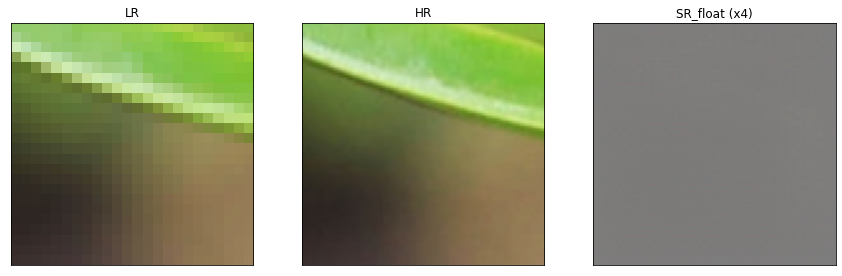

In [38]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  print(input_details)
  shape = tf.expand_dims(input, 0)
  interpreter.resize_tensor_input(tensor_index, shape.shape);         # change input size dynamically
  interpreter.allocate_tensors()
  
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #input_tensor[:, :] = input
  # print(input_tensor.shape)
  scale, zero_point = input_details['quantization']
  
  input = np.float32(input)/255.0
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def lr2sr(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])[0]
  
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = ((scale * (output - zero_point))+1)*127.5
  

  output = tf.cast(output, tf.uint8)
  # print(output)
  return output

interpreter = tf.lite.Interpreter('/content/super-resolution_train/weights/srgan/srgan_quant.tflite')
interpreter.allocate_tensors()

dd = valid_ds.take(1)
for image, label in dd:
  lr = image[2]
  hr = label[2]
  # uncomment to resize image to model input size
  # lr = tf.image.resize(lr, [64,64])    
  # hr = tf.image.resize(lr, [256,256])
  # lr = tf.cast(lr, tf.uint8)
  # hr = tf.cast(hr, tf.uint8)



sr_raw = resolve_single(model, lr)
sr_q = lr2sr(interpreter, lr)

plot_images(lr, hr, sr_q)

# tf.keras.utils.save_img('/content/super-resolution/demo/sr_float.png', sr_raw)
# tf.keras.utils.save_img('/content/super-resolution/demo/sr_quant.png', sr_q)
# tf.keras.utils.save_img('/content/super-resolution/demo/lr.png', lr)
# tf.keras.utils.save_img('/content/super-resolution/demo/hr.png', hr)

In [39]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  33381      0 --:--:-- --:--:-- --:--:-- 33381
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://security

In [24]:
! edgetpu_compiler -s -a /content/super-resolution_train/weights/srgan/srgan_quant.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1140 ms.

Input model: /content/super-resolution_train/weights/srgan/srgan_quant.tflite
Input size: 368.99KiB
Output model: srgan_quant_edgetpu.tflite
Output size: 536.62KiB
On-chip memory used for caching model parameters: 309.25KiB
On-chip memory remaining for caching model parameters: 7.05MiB
Off-chip memory used for streaming uncached model parameters: 17.00KiB
Number of Edge TPU subgraphs: 1
Total number of operations: 109
Operation log: srgan_quant_edgetpu.log

Operator                       Count      Status

TANH                           1          Mapped to Edge TPU
ADD                            17         Mapped to Edge TPU
PRELU                          17         Mapped to Edge TPU
CONV_2D                        35         Mapped to Edge TPU
TRANSPOSE_CONV                 2          Mapped to Edge TPU
DEPTHWISE_CONV_2D              35         Mapped